# 231030 - Comparison to Borsos2019 & Rooijers2019

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/0_Preimplantation.QC.part2.correlation_with_Borsos_and_NBT/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno.genotype.unique()

array(['homozygous', '129S1/SvImJ_x_CAST/EiJ', 'CBAB6F1_x_CAST/EiJ',
       'CAGGDamLMNB1_x_CAGGCRE', 'C57BL/6J_x_JF1/Ms'], dtype=object)

In [8]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.treatment.isin(['no_treatment'])]
anno = anno[anno.genotype.isin(['homozygous', '129S1/SvImJ_x_CAST/EiJ', 'CBAB6F1_x_CAST/EiJ'])]
anno = anno.set_index('damid_name')
anno = anno[anno.DamID_PASS]
anno = anno[anno.cellcount == 1]

In [9]:
anno.groupby(['stage', 'genotype', 'treatment']).size()

stage   genotype                treatment   
2cell   CBAB6F1_x_CAST/EiJ      no_treatment     26
        homozygous              no_treatment    197
8cell   CBAB6F1_x_CAST/EiJ      no_treatment     21
        homozygous              no_treatment    183
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment    268
zygote  CBAB6F1_x_CAST/EiJ      no_treatment     14
        homozygous              no_treatment    107
dtype: int64

__Generate a samplesheet for in silico populations__

In [10]:
anno_comb = anno[anno.DamID_PASS].groupby(['stage', 'fusion_construct', 'genotype', 'treatment', 'is_heterozygous']).size().reset_index().drop(columns=[0])
anno_comb['stage'] = pd.Categorical(anno_comb['stage'], categories=['zygote', '2cell', '8cell', 'morula', 'early_blastocyst', 'mESC'])
anno_comb['is_singlecell'] = True
anno_comb.loc[anno_comb.stage.isin(['morula', 'early_blastocyst']), 'is_singlecell'] = False
anno_comb = anno_comb.sort_values(by=['stage', 'is_heterozygous', 'genotype', 'treatment'])
anno_comb

,stage,fusion_construct,genotype,treatment,is_heterozygous,is_singlecell
6,zygote,Dam-Lmnb1,homozygous,no_treatment,False,True
5,zygote,Dam-Lmnb1,CBAB6F1_x_CAST/EiJ,no_treatment,True,True
1,2cell,Dam-Lmnb1,homozygous,no_treatment,False,True
0,2cell,Dam-Lmnb1,CBAB6F1_x_CAST/EiJ,no_treatment,True,True
3,8cell,Dam-Lmnb1,homozygous,no_treatment,False,True
2,8cell,Dam-Lmnb1,CBAB6F1_x_CAST/EiJ,no_treatment,True,True
4,mESC,Dam-Lmnb1,129S1/SvImJ_x_CAST/EiJ,no_treatment,True,True


## 1.2 Loading mappability

In [11]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

## 1.3 Loading data

__Single-cell counts__

In [12]:
damid_counts = ld.load_sample_damid_counts(COUNTS, anno, BINSIZE, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ
Dam-Lmnb1 homozygous


__Contact Frequency__

In [13]:
if BINSIZE >= 100000:
    contact_freq =  dict()

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

        # load combined
        gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        name = (info[1], info[2])
        assert name not in contact_freq
        contact_freq[name] =  load_count_file(fn)


__in silico populations__

In [14]:
damid_insilico = dict()

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):
    
    assert len(anno.fusion_construct.unique()) == 1
    
    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(
        construct = info[0], stage = info[1], treatment = info[3], 
        sample = '1cell', genotype = gt_name, binsize=BINSIZE
    )
    fns = glob(fn)
    print(info, len(fns))
    assert len(fns) == 1
    
    for fn in fns:
        counts = load_count_file(fn)
        counts = {c: counts[c].astype(int) for c in chrom_order}
        
        name = (info[1], info[2])
        assert name not in damid_insilico
        damid_insilico[name] = counts
                

('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', 'mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment', False) 1


__Normalization of _in silico_ populations__

In [15]:
damid_insilico_rpkm = dict()
damid_insilico_logoe = dict()

mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)

# Normalize DamID data
for sample in damid_insilico:
    counts = {c: np.copy(damid_insilico[sample][c]) for c in chrom_order}
    
    rpkm = rpkm_normalize(counts, binsize=BINSIZE)
    damid_insilico_rpkm[sample] = rpkm
    
    logoe = {c: np.log2( (np.copy(rpkm[c]) + 0.1) / (mapab_rpkm[c] + .1) ) for c in chrom_order}
    damid_insilico_logoe[sample] = logoe

# 2. Loading Borsos DamID1 data

## 2.1 Loading samplesheet

In [16]:
fn = '../../GSE112551/metadata/FR200928.GSE112551.metadata.quality_stats.tsv'
dam1_anno = pd.read_table(fn)
dam1_anno = dam1_anno[(dam1_anno.treatment == 'no_treatment') & (dam1_anno.strain != 'CAST_female_x_C57BL_6NJ_male')]
dam1_anno = dam1_anno[dam1_anno.fusion_construct == 'Dam-LMNB1']
dam1_anno = dam1_anno[dam1_anno.stage.isin(['zygote', '2cell_embryo', '8cell_embryo', 'mESC'])]
dam1_anno['stage_name'] = dam1_anno['stage'].values
dam1_anno['stage'] = dam1_anno['stage_name'].apply(func = lambda s: s.replace('_embryo', ''))

__Summarize samplesheet into distinct conditions__

In [17]:
dam1_comb = dam1_anno.groupby(['strain', 'fusion_construct', 'stage', 'stage_name', 'treatment', 'hybrid']).size().reset_index().drop(columns=0)
dam1_comb['sample'] = dam1_comb.apply(axis=1, func = lambda r: '%s:%s' % (r['stage'], r['fusion_construct']))

ind = dam1_comb['sample'].duplicated()
print(ind.sum())

0


## 2.2 Load data - _in silico_ populations of distinct biological conditions
Samples only differing in cellcount are merged.

In [18]:
from collections import defaultdict

In [19]:
FNFMT = '../../GSE112551/data/merged_hdf5/FR230814.GSE112551.{fusion}.{stage}.{treatment}.{strain}.{parent}.{norm}.binsize_{binsize:d}.hdf5'

In [20]:
dam1_insilico_counts = dict()
dam1_insilico_rpkm = dict()
dam1_insilico_logoe = dict()
tmp = {'combCOUNTS': dam1_insilico_counts, 'combRPKM': dam1_insilico_rpkm, 'combLog2OE': dam1_insilico_logoe}

for norm, outdict in tmp.items():
    
    for _, row in dam1_comb.iterrows():
        
        fn = FNFMT.format(fusion=row['fusion_construct'], stage=row['stage_name'], treatment=row['treatment'], strain=row['strain'], parent='combined', norm=norm, binsize=BINSIZE)
        
        outdict[row['stage']] = load_count_file(fn)

__Load mappability__

In [21]:
FNFMT = '../../GSE112551/data/merged/FR230814.GSE112551.average_rpkm.{strain}.{parent}.binsize_{binsize:d}.tsv.gz'

dam1_map = dict()

for strain in dam1_anno['strain'].unique():
    
    parent = 'combined'
        
    fn = FNFMT.format(strain=strain, parent=parent, binsize=BINSIZE)
    df = pd.read_table(fn, dtype={'chrom': str})

    bed = df[['chrom', 'start', 'end', 'mappability_all']].copy()
#     bed = df[['chrom', 'start', 'end', 'mappability_%s' % strain]].copy()
    bed.columns = ['chrom', 'start', 'end', 'reads']
    M = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)

    dam1_map[strain] = M

# 3. Loading NBT mESC LMNB1 data

In [22]:
import os

In [23]:
indir = '../../GSE108639_NBT/data/download/'

In [24]:
files = os.listdir(indir)
files = list(filter(lambda fn: fn.endswith('bedGraph.gz'), files))
files = sorted(files)

nbt_rpkm = dict()
nbt_logoe = dict()

mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)

for fn in files:
    
    df = pd.read_table(indir + fn, names=['chrom', 'start', 'end', 'reads'])
    df['chrom'] = df['chrom'].apply(func = lambda c: c.strip('chr'))
    
    tmp = convert_bedgraph_to_hdf5dict(df, binsize=BINSIZE)
    
    fnparts = fn.split('.')
    name = (fnparts[6], fnparts[9])
    
    rpkm = {c: tmp[c][:len(mapab[c])] for c in chrom_order}
    for c in chrom_order:
        assert len(rpkm[c]) == len(mapab[c]), (c, len(rpkm[c]), len(mapab[c]))
    nbt_rpkm[name] = rpkm
    
    log2oe = {c: np.copy(rpkm[c]) for c in chrom_order}
    nbt_logoe[name] = {c: np.log2( (log2oe[c] + .1) / (mapab_rpkm[c] + .1) ) for c in chrom_order}
    
    

# 4. Comparison with Borsos2019

## 4.1 Correlation

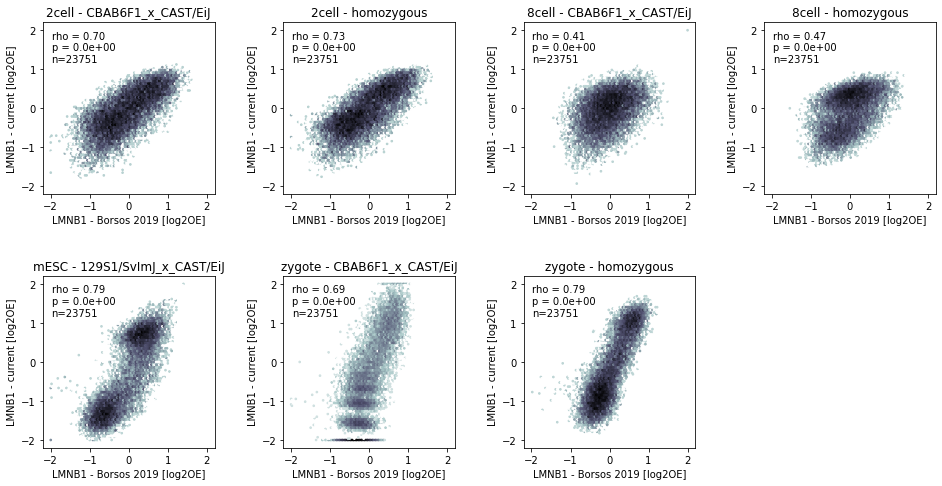

In [34]:
samples = list(damid_insilico.keys())
ncol = 4
nrow = int(np.ceil(len(samples)/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4,4*nrow))
plt.subplots_adjust(hspace=.4, wspace=.4)

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

for iplot, sample in enumerate(samples):
    
    stage = sample[0]
    X = np.concatenate([dam1_insilico_logoe[stage][c] for c in chrom_order[:-2]])[m_ind]
    Y = np.concatenate([damid_insilico_logoe[sample][c] for c in chrom_order[:-2]])[m_ind]
    
    ax = axes.flatten()[iplot]
    ax.set_title('%s - %s' % sample)
    
    ax.hexbin(X.clip(-2,2), Y.clip(-2,2), extent=[-2,2,-2,2], bins='log', mincnt=1, cmap='bone_r')
    ax.set_xlabel('LMNB1 - Borsos 2019 [log2OE]')
    ax.set_ylabel('LMNB1 - current [log2OE]')
    ax.set_aspect('equal')
    
    r, p = stats.spearmanr(X, Y)
    txt = 'rho = %.2f\np = %.1e\nn=%d' % (r,p,len(X))
    ax.text(0.05, 0.95, txt, transform=ax.transAxes, va='top', ha='left')
    
while iplot < (nrow*ncol-1):
    iplot += 1
    axes.flatten()[iplot].remove()
    
outfn = FIGOUTDIR + 'comparison_Borsos2019.correlation_LMNB1_samples.somatic_chromosomes.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

## 4.2 Tracks

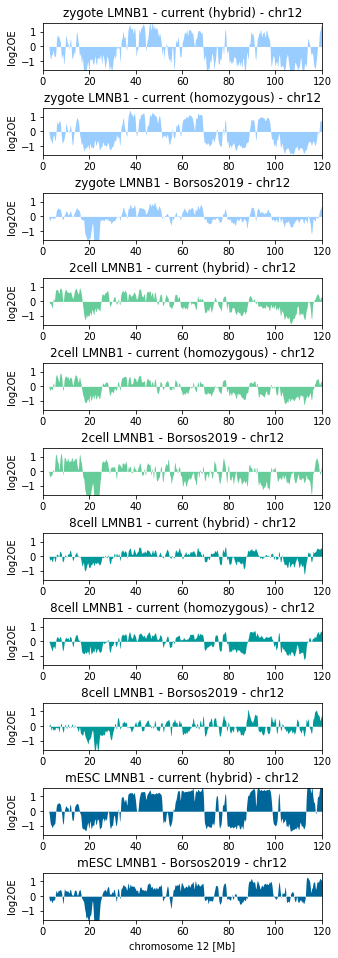

In [26]:
samples = list(damid_insilico.keys())

for chrom in ['5', '10', '8', '12', '17']:
    smooth_std = 200000
    W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
    W /= W.sum()

    nrow = len(anno_comb) + len(dam1_comb)
    fig, axes = plt.subplots(nrow, 1, figsize=(5,nrow*1.5))
    plt.subplots_adjust(hspace=.8)
    counter = 0

    for stage in stage_order:
        
        tmp = dict()
        for sample in samples:
            if sample[0] == stage:
                n = 'current (homozygous)' if sample[1] == 'homozygous' else 'current (hybrid)'
                tmp[n] = damid_insilico_rpkm[sample][chrom]
        tmp['Borsos2019'] = dam1_insilico_rpkm[stage][chrom]
        
        strain = dam1_comb.loc[dam1_comb.stage==stage,'strain'].values
        assert len(strain) == 1, strain
        tmp_m = {'current (homozygous)': mapab, 'current (hybrid)': mapab, 'Borsos2019': dam1_map[strain[0]]}

        for study, Y in tmp.items():

            # smooth
            Y = fftconvolve(Y, W, mode='same')
            m = {c: np.copy(tmp_m[study][c]) for c in chrom_order}
            m = rpkm_normalize(m, binsize=BINSIZE)
            m = fftconvolve(m[chrom], W, mode='same')
            Yoe = np.log2( (Y + .1) / (m + .1) )
            X = np.arange(0, len(Y)*BINSIZE, BINSIZE)/1e6

            ax = axes[counter]
            counter += 1

            ax.set_title('%s LMNB1 - %s - chr%s' % (stage, study, chrom))

            clr = color_dict['stage'][stage]
            ax.fill_between(X, 0, Yoe, lw=0, color=clr)
            ax.set_xlim(0, X[-1])
            ax.set_ylim(-1.6,1.6)

            ax.set_ylabel('log2OE')
    ax.set_xlabel('chromosome %s [Mb]' % chrom)

    outfn = FIGOUTDIR + 'comparison_Borsos2019.example_track.chr%s.pdf' % chrom
    plt.savefig(outfn, bbox_inches='tight')
    if chrom == '12':
        plt.show()
    plt.close()

# 5. Comparison with Rooijers2019

## 5.1 Correlation

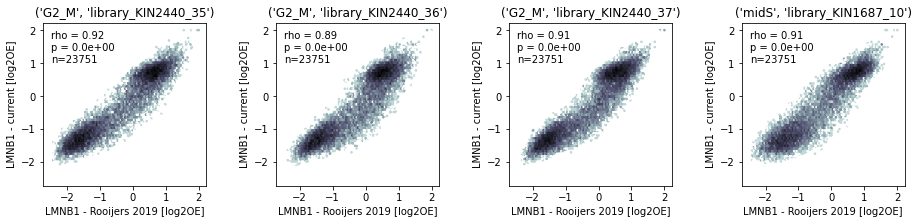

In [33]:
ncol = len(nbt_logoe.keys())
fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,3))

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

stage = 'mESC'
sample = ('mESC', '129S1/SvImJ_x_CAST/EiJ')

for icol, nbt_sample in enumerate(nbt_logoe.keys()):
    
    X = np.concatenate([nbt_logoe[nbt_sample][c] for c in chrom_order[:-2]])[m_ind]
    Y = np.concatenate([damid_insilico_logoe[sample][c] for c in chrom_order[:-2]])[m_ind]
    
    ax = axes[icol]
    ax.set_title(nbt_sample)
    
    ax.hexbin(X.clip(-2.5,2), Y.clip(-2.5,2), extent=[-2.5,2,-2.5,2], bins='log', mincnt=1, cmap='bone_r')
    ax.set_xlabel('LMNB1 - Rooijers 2019 [log2OE]')
    ax.set_ylabel('LMNB1 - current [log2OE]')
    ax.set_aspect('equal')
    
    r, p = stats.spearmanr(X, Y)
    txt = 'rho = %.2f\np = %.1e\nn=%d' % (r,p,len(X))
    ax.text(0.05, 0.95, txt, transform=ax.transAxes, va='top', ha='left')
    
outfn = FIGOUTDIR + 'comparison_Rooijers2019.correlation_mESC_LMNB1_samples.somatic_chromosomes.pdf'
plt.savefig(outfn, bbox_inches='tight')

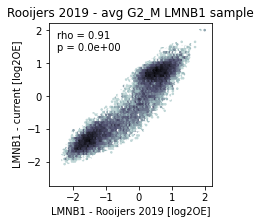

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
stage = 'mESC'
sample = ('mESC', '129S1/SvImJ_x_CAST/EiJ')

nbt_avg = list()
for nbt_sample in nbt_logoe.keys():
    if nbt_sample[0] != 'G2_M':
        continue
    X = np.concatenate([nbt_logoe[nbt_sample][c] for c in chrom_order[:-2]])[m_ind]
    nbt_avg.append(X)
nbt_avg = np.array(nbt_avg).mean(axis=0)


Y = np.concatenate([damid_insilico_logoe[sample][c] for c in chrom_order[:-2]])[m_ind]

ax.set_title('Rooijers 2019 - avg G2_M LMNB1 sample')

ax.hexbin(X.clip(-2.5,2), Y.clip(-2.5,2), extent=[-2.5,2,-2.5,2], bins='log', mincnt=1, cmap='bone_r')
ax.set_xlabel('LMNB1 - Rooijers 2019 [log2OE]')
ax.set_ylabel('LMNB1 - current [log2OE]')
ax.set_aspect('equal')

r, p = stats.spearmanr(X, Y)
txt = 'rho = %.2f\np = %.1e' % (r,p)
ax.text(0.05, 0.95, txt, transform=ax.transAxes, va='top', ha='left')
    
outfn = FIGOUTDIR + 'comparison_Rooijers2019.correlation_mESC_LMNB1_samples.avg_G2M_sample.somatic_chromosomes.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 5.2 Tracks

In [29]:

for chrom in ['5', '10', '8', '12', '17']:
    smooth_std = 200000
    W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
    W /= W.sum()

    nrow = len(nbt_logoe.keys()) + 2
    fig, axes = plt.subplots(nrow, 1, figsize=(5,nrow*1.5))
    plt.subplots_adjust(hspace=.8)
    counter = 0

    to_plot = {
        'current': damid_insilico_rpkm[('mESC', '129S1/SvImJ_x_CAST/EiJ')][chrom]
    }
    avg = list()
    for sample in nbt_rpkm:
        to_plot['Rooijers2019:%s:%s' % sample] = nbt_rpkm[sample][chrom]

        if sample[0] == 'G2_M':
            avg.append(nbt_rpkm[sample][chrom])
    to_plot['Rooijers2019:G2_M:avg'] = np.array(avg).mean(axis=0)

    m = {c: np.copy(mapab[c]) for c in chrom_order}
    m = rpkm_normalize(m, binsize=BINSIZE)
    m = fftconvolve(m[chrom], W, mode='same')

    for irow, sample in enumerate(to_plot.keys()):

        Y = to_plot[sample]

        # smooth
        Y = fftconvolve(Y, W, mode='same')

        Yoe = np.log2( (Y + .1) / (m + .1) )
        X = np.arange(0, len(Y)*BINSIZE, BINSIZE)/1e6

        ax = axes[counter]
        counter += 1

        ax.set_title('mESC LMNB1 - %s - chr%s' % (sample, chrom))

        clr = color_dict['stage'][stage]
        ax.fill_between(X, 0, Yoe, lw=0, color=clr)
        ax.set_xlim(0, X[-1])
        ax.set_ylim(-1.8,1.6)
        ax.set_ylabel('log2OE')

    ax.set_xlabel('chromosome %s [Mb]' % chrom)

    outfn = FIGOUTDIR + 'comparison_Rooijers2019.example_track.chr%s.pdf' % chrom
    plt.savefig(outfn, bbox_inches='tight')
    plt.close()

# 6. Correlation of technical replicates

In [30]:
damid_insilico_runs = dict()

rundf = anno.groupby(['stage', 'genotype', 'runid']).size()
rundf = rundf[rundf>20].reset_index()
rundf = rundf[rundf['genotype']=='homozygous']

for _, row in rundf.iterrows():

    name = (row['stage'], row['genotype'])
    if name not in damid_insilico_runs:
        damid_insilico_runs[name] = dict()
    
    
    ind = (anno['runid']==row['runid'])&(anno['stage']==row['stage'])&(anno['genotype']==row['genotype'])
    samples = anno[ind].index.values
    combcounts = {c: np.zeros_like(mapab[c]) for c in chrom_order}
    for s in samples:
        combcounts = {c: combcounts[c] + damid_counts[s][c] for c in chrom_order}
        
    damid_insilico_runs[name][row['runid']] = combcounts
        

In [31]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

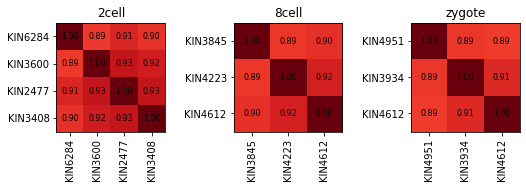

In [32]:
plotkeys = list(filter(lambda k: len(damid_insilico_runs[k].keys())>1, damid_insilico_runs.keys()))
ncol = len(plotkeys)
fig, axes = plt.subplots(1, ncol, figsize=(3*ncol,2))

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP


for icol, condition in enumerate(plotkeys):
    ax = axes[icol]
#     ax.set_title('%s - %s' % condition)
    ax.set_title(condition[0])
    
    to_plot = dict()
    for runid in damid_insilico_runs[condition]:
        
        counts = damid_insilico_runs[condition][runid]
        rpkm = rpkm_normalize(counts, BINSIZE)
        logoe = {c: np.log2( (rpkm[c] + .1) / (mapab_rpkm[c] + .1) ) for c in chrom_order}
        Y = np.concatenate([logoe[c] for c in chrom_order[:-2]])
        
        to_plot[runid] = Y[m_ind]
        
    to_plot = pd.DataFrame(to_plot)
    C = to_plot.corr(method='spearman')
    linkage = hc.linkage(C, method='average')
    order = hc.leaves_list(linkage)
    C = C.iloc[order,order]
    
    ax.imshow(C, cmap='Reds', vmin=.7, vmax=1)
    ax.set_xticks(np.arange(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticks(np.arange(C.shape[0]))
    ax.set_yticklabels(C.columns)
    
#     figw = to_plot.shape[1]
#     p = sns.clustermap(
#         C, row_linkage=linkage, col_linkage=linkage, 
#         cmap='Reds', vmin=0, vmax=1,
#         figsize=(figw,figw)
#     )
#     p.ax_cbar.set_ylabel('Spearman\'s rho')

    for i in range(len(C)):
        for j in range(len(C)):
            t = '%.2f' % C.iloc[i,j]
            ax.text(j, i, t, ha='center', va='center', fontsize=8)
    
#     plt.title('%s - %s' % condition)
#     plt.show()
#     plt.close()